In [ ]:

# ============================================================================
# PART 1: SETUP & IMPORTS
# ============================================================================

In [1]:
!pip install -q kaggle opendatasets

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix
)

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.8.0+cu126
Torchvision Version: 0.23.0+cu126
CUDA Available: True
GPU: Tesla T4


In [3]:
from google.colab import files

print("📁 Please upload your kaggle.json file:")
uploaded = files.upload()

# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("\n📥 Downloading NIH Chest X-ray Dataset (this may take 5-10 minutes)...")
!kaggle datasets download -d nih-chest-xrays/sample
!unzip -q sample.zip -d chest_xray_data

print("✅ Dataset downloaded!")

# Paths
DATA_DIR = "chest_xray_data/sample/images"
LABELS_FILE = "chest_xray_data/sample_labels.csv"

📁 Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json

📥 Downloading NIH Chest X-ray Dataset (this may take 5-10 minutes)...
Dataset URL: https://www.kaggle.com/datasets/nih-chest-xrays/sample
License(s): CC0-1.0
 99% 4.15G/4.20G [00:57<00:00, 173MB/s]
100% 4.20G/4.20G [00:57<00:00, 78.5MB/s]
✅ Dataset downloaded!


In [4]:
df = pd.read_csv(LABELS_FILE)

print(f"\n📊 Dataset Overview:")
print(f"Total images: {len(df)}")
print(f"Total patients: {df['Patient ID'].nunique()}")
print(f"\nFirst few rows:")
print(df.head())

# Disease labels
DISEASE_LABELS = [
    'Atelectasis', 'Consolidation', 'Infiltration', 'Pneumothorax',
    'Edema', 'Emphysema', 'Fibrosis', 'Effusion', 'Pneumonia',
    'Pleural_thickening', 'Cardiomegaly', 'Nodule', 'Mass', 'Hernia'
]


📊 Dataset Overview:
Total images: 5606
Total patients: 4230

First few rows:
        Image Index                                     Finding Labels  \
0  00000013_005.png  Emphysema|Infiltration|Pleural_Thickening|Pneu...   
1  00000013_026.png                             Cardiomegaly|Emphysema   
2  00000017_001.png                                         No Finding   
3  00000030_001.png                                        Atelectasis   
4  00000032_001.png                        Cardiomegaly|Edema|Effusion   

   Follow-up #  Patient ID Patient Age Patient Gender View Position  \
0            5          13        060Y              M            AP   
1           26          13        057Y              M            AP   
2            1          17        077Y              M            AP   
3            1          30        079Y              M            PA   
4            1          32        055Y              F            AP   

   OriginalImageWidth  OriginalImageHeight  Origin

In [5]:
# Create binary columns for each disease
for disease in DISEASE_LABELS:
    df[disease] = df['Finding Labels'].apply(lambda x: 1 if disease in x else 0)

In [6]:
# Count diseases
print(f"\n💊 Disease Distribution:")
disease_counts = df[DISEASE_LABELS].sum().sort_values(ascending=False)
print(disease_counts)


💊 Disease Distribution:
Infiltration          967
Effusion              644
Atelectasis           508
Nodule                313
Mass                  284
Pneumothorax          271
Consolidation         226
Cardiomegaly          141
Emphysema             127
Edema                 118
Fibrosis               84
Pneumonia              62
Hernia                 13
Pleural_thickening      0
dtype: int64


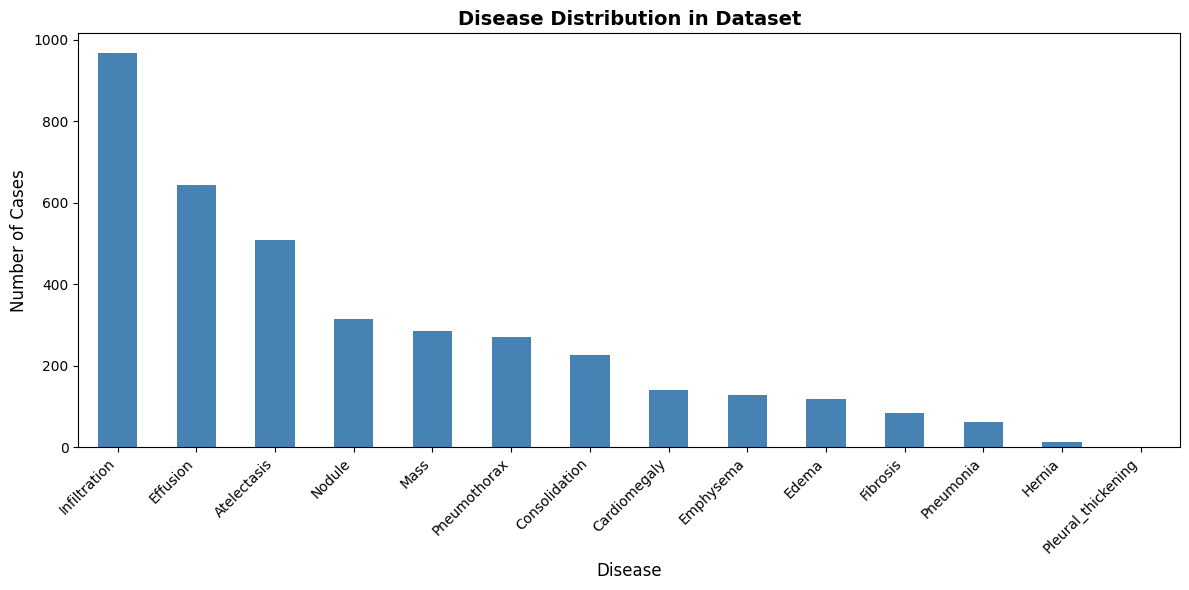

In [7]:
# Visualize disease distribution
plt.figure(figsize=(12, 6))
disease_counts.plot(kind='bar', color='steelblue')
plt.title('Disease Distribution in Dataset', fontsize=14, fontweight='bold')
plt.xlabel('Disease', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('disease_distribution.png', dpi=100)
plt.show()

In [8]:
# Check for class imbalance
print(f"\n⚖️ Class Imbalance Ratio:")
max_count = disease_counts.max()
for disease in disease_counts.index:
    ratio = max_count / disease_counts[disease]
    print(f"{disease:20s}: 1:{ratio:.1f}")


⚖️ Class Imbalance Ratio:
Infiltration        : 1:1.0
Effusion            : 1:1.5
Atelectasis         : 1:1.9
Nodule              : 1:3.1
Mass                : 1:3.4
Pneumothorax        : 1:3.6
Consolidation       : 1:4.3
Cardiomegaly        : 1:6.9
Emphysema           : 1:7.6
Edema               : 1:8.2
Fibrosis            : 1:11.5
Pneumonia           : 1:15.6
Hernia              : 1:74.4
Pleural_thickening  : 1:inf


/tmp/ipython-input-2936211825.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = max_count / disease_counts[disease]


In [10]:
# DATA PREPARATION

class ChestXrayDataset(Dataset):
    """Custom Dataset for Chest X-ray images"""

    def __init__(self, dataframe, image_dir, labels, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_dir = image_dir
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Get image path
        img_name = self.dataframe.iloc[idx]['Image Index']
        img_path = os.path.join(self.image_dir, img_name)

        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            # If image fails to load, return a black image
            image = Image.new('RGB', (224, 224), color='black')
            print(f"Warning: Failed to load {img_name}")

        # Get labels
        label_vector = self.dataframe.iloc[idx][self.labels].values.astype(np.float32)

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label_vector)


In [11]:
# Data transforms with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])


In [12]:
def split_dataset(df, test_size=0.15, val_size=0.15, random_state=42):
    """Split dataset by patient ID to prevent data leakage"""

    patients = df['Patient ID'].unique()

    # Split patients
    train_patients, test_patients = train_test_split(
        patients, test_size=test_size, random_state=random_state
    )
    train_patients, val_patients = train_test_split(
        train_patients, test_size=val_size/(1-test_size), random_state=random_state
    )

    # Create dataframes
    train_df = df[df['Patient ID'].isin(train_patients)]
    val_df = df[df['Patient ID'].isin(val_patients)]
    test_df = df[df['Patient ID'].isin(test_patients)]

    print(f"\n📊 Data Split:")
    print(f"Train: {len(train_df)} images ({len(train_patients)} patients)")
    print(f"Val:   {len(val_df)} images ({len(val_patients)} patients)")
    print(f"Test:  {len(test_df)} images ({len(test_patients)} patients)")

    return train_df, val_df, test_df

In [13]:
# Split data
train_df, val_df, test_df = split_dataset(df)


📊 Data Split:
Train: 3925 images (2960 patients)
Val:   840 images (635 patients)
Test:  841 images (635 patients)


In [14]:
# Create datasets
train_dataset = ChestXrayDataset(train_df, DATA_DIR, DISEASE_LABELS, train_transform)
val_dataset = ChestXrayDataset(val_df, DATA_DIR, DISEASE_LABELS, val_transform)
test_dataset = ChestXrayDataset(test_df, DATA_DIR, DISEASE_LABELS, val_transform)


In [15]:
# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                         num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                       num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=2, pin_memory=True)

print(f"\n✅ Dataloaders created:")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


✅ Dataloaders created:
Train batches: 123
Val batches: 27
Test batches: 27



🖼️ Sample Images:


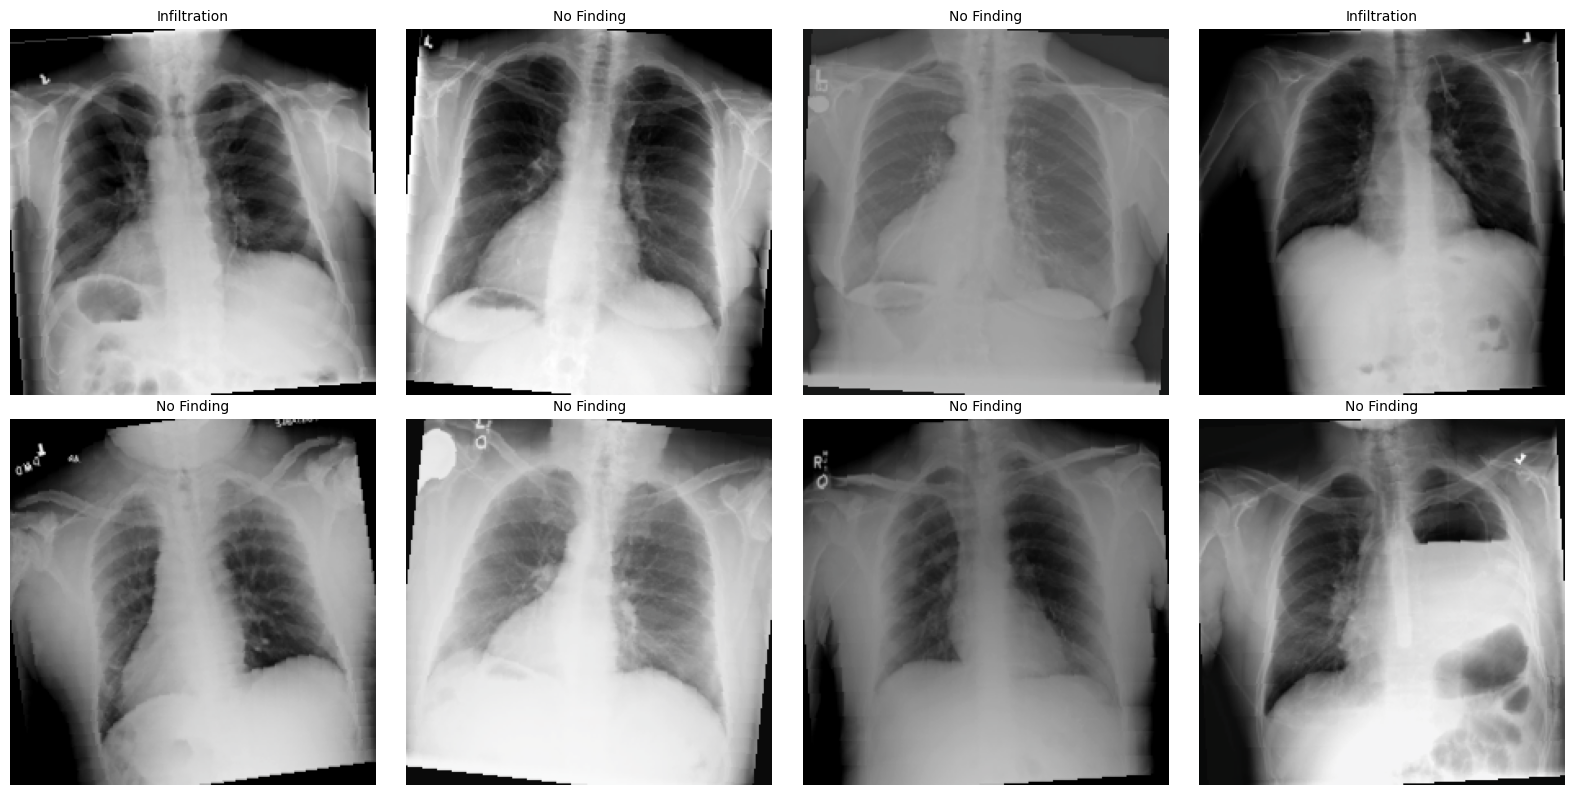

In [16]:
# Visualize sample images
def show_sample_images(dataloader, num_images=8):
    """Display sample images from dataloader"""

    images, labels = next(iter(dataloader))

    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        img = images[i].permute(1, 2, 0).numpy()

        # Denormalize
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)

        axes[i].imshow(img)

        # Get disease names
        label_indices = torch.where(labels[i] == 1)[0]
        if len(label_indices) > 0:
            diseases = [DISEASE_LABELS[idx] for idx in label_indices]
            title = ', '.join(diseases[:3])  # Show max 3 diseases
            if len(diseases) > 3:
                title += f' +{len(diseases)-3} more'
        else:
            title = 'No Finding'

        axes[i].set_title(title, fontsize=10)
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=100)
    plt.show()

print("\n🖼️ Sample Images:")
show_sample_images(train_loader)


In [17]:
class ChestXrayModel(nn.Module):
    """DenseNet-121 for multi-label chest X-ray classification"""

    def __init__(self, num_classes=14, pretrained=True, dropout=0.5):
        super(ChestXrayModel, self).__init__()

        # Load pre-trained DenseNet-121
        self.densenet = models.densenet121(pretrained=pretrained)

        # Get number of features
        num_features = self.densenet.classifier.in_features

        # Replace classifier
        self.densenet.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.densenet(x)

In [18]:
# Create model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ChestXrayModel(num_classes=14, pretrained=True, dropout=0.5)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n🧠 Model Architecture:")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Device: {device}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 108MB/s]



🧠 Model Architecture:
Total parameters: 6,968,206
Trainable parameters: 6,968,206
Device: cuda


In [19]:
# Calculate class weights for imbalanced dataset
def calculate_class_weights(train_df, labels):
    """Calculate pos_weight for BCEWithLogitsLoss"""

    pos_counts = train_df[labels].sum().values
    neg_counts = len(train_df) - pos_counts

    # pos_weight = neg_count / pos_count
    pos_weights = neg_counts / (pos_counts + 1)  # +1 to avoid division by zero

    print(f"\n⚖️ Class Weights (pos_weight):")
    for label, weight in zip(labels, pos_weights):
        print(f"{label:20s}: {weight:.2f}")

    return torch.tensor(pos_weights, dtype=torch.float32)

# Get class weights
class_weights = calculate_class_weights(train_df, DISEASE_LABELS).to(device)

# Loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',      # Maximize AUC
    factor=0.5,      # Reduce LR by half
    patience=2,      # Wait 2 epochs
    min_lr=1e-7
)

print(f"\n✅ Training Setup:")
print(f"Loss: BCEWithLogitsLoss (weighted)")
print(f"Optimizer: Adam (lr=0.0001)")
print(f"Scheduler: ReduceLROnPlateau")


⚖️ Class Weights (pos_weight):
Atelectasis         : 9.50
Consolidation       : 24.17
Infiltration        : 4.74
Pneumothorax        : 19.88
Edema               : 48.70
Emphysema           : 44.65
Fibrosis            : 67.88
Effusion            : 7.78
Pneumonia           : 90.30
Pleural_thickening  : 3925.00
Cardiomegaly        : 42.62
Nodule              : 15.43
Mass                : 17.01
Hernia              : 326.17

✅ Training Setup:
Loss: BCEWithLogitsLoss (weighted)
Optimizer: Adam (lr=0.0001)
Scheduler: ReduceLROnPlateau


In [20]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(loader, desc="Training")

    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    return running_loss / len(loader)

In [21]:
def validate(model, loader, criterion, device, threshold=0.5):
    """Validate model and calculate metrics"""
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validating"):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            # Get predictions (sigmoid for probabilities)
            predictions = torch.sigmoid(outputs).cpu().numpy()
            all_predictions.append(predictions)
            all_labels.append(labels.cpu().numpy())

    # Concatenate all batches
    all_predictions = np.vstack(all_predictions)
    all_labels = np.vstack(all_labels)

    # Calculate metrics
    avg_loss = running_loss / len(loader)

    # AUC-ROC per disease
    auc_scores = []
    for i in range(len(DISEASE_LABELS)):
        if len(np.unique(all_labels[:, i])) > 1:
            auc = roc_auc_score(all_labels[:, i], all_predictions[:, i])
            auc_scores.append(auc)
        else:
            auc_scores.append(0.0)

    mean_auc = np.mean([s for s in auc_scores if s > 0])

    # Binary predictions
    predictions_binary = (all_predictions > threshold).astype(int)

    # Accuracy (exact match for multi-label)
    exact_match_accuracy = np.mean(np.all(predictions_binary == all_labels, axis=1))

    # Hamming accuracy (per-label accuracy)
    hamming_accuracy = np.mean(predictions_binary == all_labels)

    # F1, Precision, Recall
    f1 = f1_score(all_labels, predictions_binary, average='macro', zero_division=0)
    precision = precision_score(all_labels, predictions_binary, average='macro', zero_division=0)
    recall = recall_score(all_labels, predictions_binary, average='macro', zero_division=0)

    return {
        'loss': avg_loss,
        'auc': mean_auc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'exact_match_accuracy': exact_match_accuracy,
        'hamming_accuracy': hamming_accuracy,
        'auc_per_disease': auc_scores,
        'predictions': all_predictions,
        'labels': all_labels
    }


In [22]:
NUM_EPOCHS = 15
EARLY_STOP_PATIENCE = 5

print(f"\n🚀 Starting Training for {NUM_EPOCHS} epochs")
print("=" * 70)

# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_auc': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': [],
    'learning_rate': []
}

best_auc = 0.0
patience_counter = 0

for epoch in range(NUM_EPOCHS):
    print(f"\n📍 Epoch {epoch + 1}/{NUM_EPOCHS}")
    print("-" * 70)

    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_metrics = validate(model, val_loader, criterion, device)

    # Update scheduler
    scheduler.step(val_metrics['auc'])
    current_lr = optimizer.param_groups[0]['lr']

    # Save history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_metrics['loss'])
    history['val_auc'].append(val_metrics['auc'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])
    history['learning_rate'].append(current_lr)

    # Print results
    print(f"\n📊 Results:")
    print(f"   Train Loss:  {train_loss:.4f}")
    print(f"   Val Loss:    {val_metrics['loss']:.4f}")
    print(f"   Val AUC:     {val_metrics['auc']:.4f} ⭐")
    print(f"   Val F1:      {val_metrics['f1']:.4f}")
    print(f"   Val Prec:    {val_metrics['precision']:.4f}")
    print(f"   Val Recall:  {val_metrics['recall']:.4f}")
    print(f"   Learning Rate: {current_lr:.2e}")

    # Save best model
    if val_metrics['auc'] > best_auc:
        best_auc = val_metrics['auc']
        patience_counter = 0

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_auc': val_metrics['auc'],
            'val_f1': val_metrics['f1'],
            'history': history
        }, 'best_model.pth')

        print(f"   ✅ Saved best model! (AUC: {val_metrics['auc']:.4f})")
    else:
        patience_counter += 1
        print(f"   ⏳ No improvement ({patience_counter}/{EARLY_STOP_PATIENCE})")

    # Early stopping
    if patience_counter >= EARLY_STOP_PATIENCE:
        print(f"\n⚠️ Early stopping triggered after {epoch + 1} epochs")
        break

print("\n" + "=" * 70)
print(f"🎉 Training Complete!")
print(f"🏆 Best Validation AUC: {best_auc:.4f}")



🚀 Starting Training for 15 epochs

📍 Epoch 1/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.66it/s]



📊 Results:
   Train Loss:  1.2491
   Val Loss:    1.1028
   Val AUC:     0.6371 ⭐
   Val F1:      0.1102
   Val Prec:    0.0670
   Val Recall:  0.4134
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.6371)

📍 Epoch 2/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.68it/s]



📊 Results:
   Train Loss:  1.1147
   Val Loss:    1.0646
   Val AUC:     0.6816 ⭐
   Val F1:      0.1226
   Val Prec:    0.0731
   Val Recall:  0.5566
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.6816)

📍 Epoch 3/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]



📊 Results:
   Train Loss:  1.0663
   Val Loss:    1.0261
   Val AUC:     0.7146 ⭐
   Val F1:      0.1333
   Val Prec:    0.0814
   Val Recall:  0.5271
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.7146)

📍 Epoch 4/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.59it/s]



📊 Results:
   Train Loss:  1.0133
   Val Loss:    1.0218
   Val AUC:     0.7218 ⭐
   Val F1:      0.1403
   Val Prec:    0.0876
   Val Recall:  0.5022
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.7218)

📍 Epoch 5/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:17<00:00,  1.57it/s]



📊 Results:
   Train Loss:  0.9533
   Val Loss:    0.9526
   Val AUC:     0.7435 ⭐
   Val F1:      0.1493
   Val Prec:    0.0917
   Val Recall:  0.5719
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.7435)

📍 Epoch 6/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]



📊 Results:
   Train Loss:  0.9247
   Val Loss:    0.9880
   Val AUC:     0.7339 ⭐
   Val F1:      0.1488
   Val Prec:    0.0956
   Val Recall:  0.4956
   Learning Rate: 1.00e-04
   ⏳ No improvement (1/5)

📍 Epoch 7/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.61it/s]



📊 Results:
   Train Loss:  0.8778
   Val Loss:    0.9666
   Val AUC:     0.7508 ⭐
   Val F1:      0.1449
   Val Prec:    0.0903
   Val Recall:  0.5458
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.7508)

📍 Epoch 8/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]



📊 Results:
   Train Loss:  0.8255
   Val Loss:    1.0527
   Val AUC:     0.7326 ⭐
   Val F1:      0.1588
   Val Prec:    0.1088
   Val Recall:  0.4002
   Learning Rate: 1.00e-04
   ⏳ No improvement (1/5)

📍 Epoch 9/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]



📊 Results:
   Train Loss:  0.7915
   Val Loss:    0.9902
   Val AUC:     0.7527 ⭐
   Val F1:      0.1679
   Val Prec:    0.1103
   Val Recall:  0.5095
   Learning Rate: 1.00e-04
   ✅ Saved best model! (AUC: 0.7527)

📍 Epoch 10/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.66it/s]



📊 Results:
   Train Loss:  0.7235
   Val Loss:    0.9983
   Val AUC:     0.7526 ⭐
   Val F1:      0.1692
   Val Prec:    0.1108
   Val Recall:  0.4681
   Learning Rate: 1.00e-04
   ⏳ No improvement (1/5)

📍 Epoch 11/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.68it/s]



📊 Results:
   Train Loss:  0.6820
   Val Loss:    1.1005
   Val AUC:     0.7362 ⭐
   Val F1:      0.1619
   Val Prec:    0.1033
   Val Recall:  0.4526
   Learning Rate: 1.00e-04
   ⏳ No improvement (2/5)

📍 Epoch 12/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.64it/s]



📊 Results:
   Train Loss:  0.6730
   Val Loss:    1.1277
   Val AUC:     0.7404 ⭐
   Val F1:      0.1689
   Val Prec:    0.1096
   Val Recall:  0.4616
   Learning Rate: 5.00e-05
   ⏳ No improvement (3/5)

📍 Epoch 13/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.60it/s]



📊 Results:
   Train Loss:  0.6090
   Val Loss:    1.1450
   Val AUC:     0.7346 ⭐
   Val F1:      0.1737
   Val Prec:    0.1189
   Val Recall:  0.4271
   Learning Rate: 5.00e-05
   ⏳ No improvement (4/5)

📍 Epoch 14/15
----------------------------------------------------------------------


Validating: 100%|██████████| 27/27 [00:16<00:00,  1.59it/s]



📊 Results:
   Train Loss:  0.5633
   Val Loss:    1.1817
   Val AUC:     0.7332 ⭐
   Val F1:      0.1786
   Val Prec:    0.1200
   Val Recall:  0.3960
   Learning Rate: 5.00e-05
   ⏳ No improvement (5/5)

⚠️ Early stopping triggered after 14 epochs

🎉 Training Complete!
🏆 Best Validation AUC: 0.7527


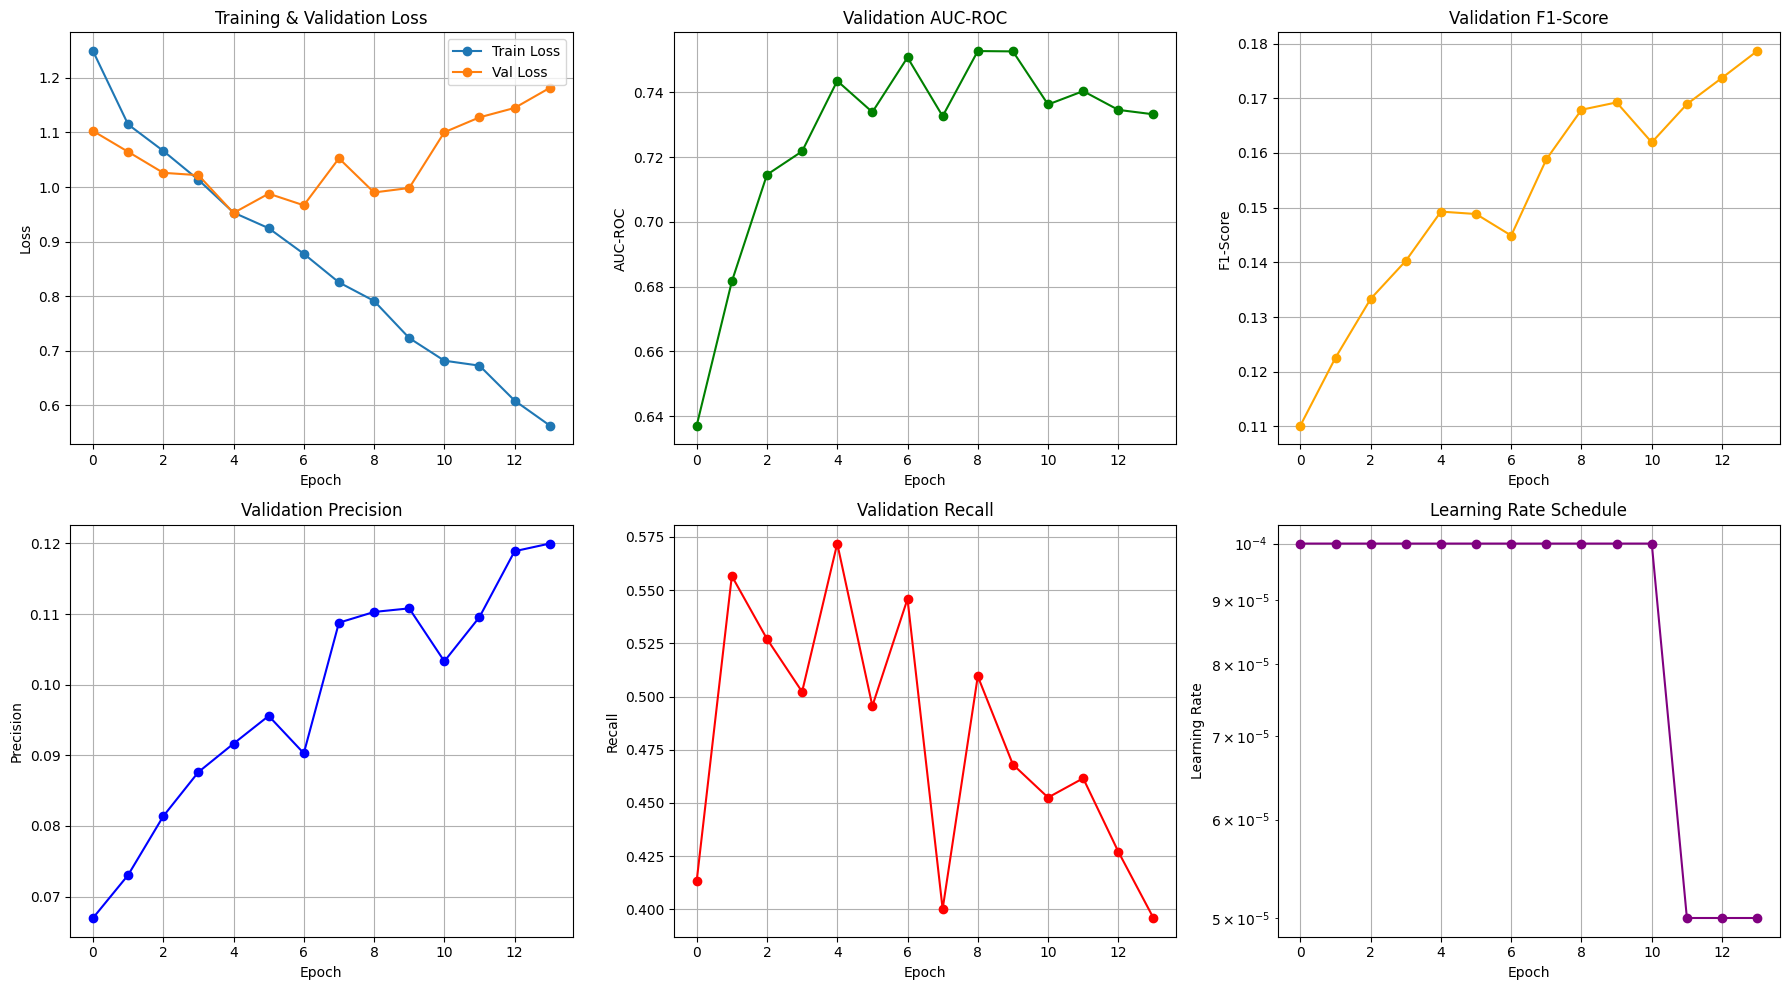

In [23]:
def plot_training_history(history):
    """Plot training history"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))

    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0, 0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training & Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # AUC
    axes[0, 1].plot(history['val_auc'], marker='o', color='green')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('AUC-ROC')
    axes[0, 1].set_title('Validation AUC-ROC')
    axes[0, 1].grid(True)

    # F1
    axes[0, 2].plot(history['val_f1'], marker='o', color='orange')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1-Score')
    axes[0, 2].set_title('Validation F1-Score')
    axes[0, 2].grid(True)

    # Precision
    axes[1, 0].plot(history['val_precision'], marker='o', color='blue')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].set_title('Validation Precision')
    axes[1, 0].grid(True)

    # Recall
    axes[1, 1].plot(history['val_recall'], marker='o', color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].set_title('Validation Recall')
    axes[1, 1].grid(True)

    # Learning Rate
    axes[1, 2].plot(history['learning_rate'], marker='o', color='purple')
    axes[1, 2].set_xlabel('Epoch')
    axes[1, 2].set_ylabel('Learning Rate')
    axes[1, 2].set_title('Learning Rate Schedule')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_training_history(history)

In [24]:
print("\n🔍 Evaluating on Test Set...")
print("=" * 70)

# Load best model
checkpoint = torch.load('best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])

# Evaluate
test_metrics = validate(model, test_loader, criterion, device, threshold=0.5)

print(f"\n📊 TEST SET RESULTS:")
print(f"Loss:      {test_metrics['loss']:.4f}")
print(f"AUC:       {test_metrics['auc']:.4f}")
print(f"F1:        {test_metrics['f1']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")

# Per-disease metrics
print(f"\n💊 PER-DISEASE METRICS:")
print("-" * 70)
print(f"{'Disease':<20} {'AUC':>8} {'F1':>8} {'Precision':>10} {'Recall':>10}")
print("-" * 70)

results = {}
for i, disease in enumerate(DISEASE_LABELS):
    labels = test_metrics['labels'][:, i]
    predictions = test_metrics['predictions'][:, i]
    pred_binary = (predictions > 0.5).astype(int)

    if len(np.unique(labels)) > 1:
        auc_score = roc_auc_score(labels, predictions)
    else:
        auc_score = 0.0

    f1 = f1_score(labels, pred_binary, zero_division=0)
    precision = precision_score(labels, pred_binary, zero_division=0)
    recall = recall_score(labels, pred_binary, zero_division=0)

    results[disease] = {
        'AUC': float(auc_score),
        'F1': float(f1),
        'Precision': float(precision),
        'Recall': float(recall)
    }

    print(f"{disease:<20} {auc_score:>8.3f} {f1:>8.3f} {precision:>10.3f} {recall:>10.3f}")

# Overall
mean_auc = np.mean([r['AUC'] for r in results.values() if r['AUC'] > 0])
mean_f1 = np.mean([r['F1'] for r in results.values()])

print("-" * 70)
print(f"{'OVERALL MEAN':<20} {mean_auc:>8.3f} {mean_f1:>8.3f}")
print("=" * 70)

# Save results
with open('test_results.json', 'w') as f:
    json.dump(results, f, indent=2)


🔍 Evaluating on Test Set...


Validating: 100%|██████████| 27/27 [00:18<00:00,  1.49it/s]



📊 TEST SET RESULTS:
Loss:      1.1355
AUC:       0.7448
F1:        0.1704
Precision: 0.1119
Recall:    0.4714

💊 PER-DISEASE METRICS:
----------------------------------------------------------------------
Disease                   AUC       F1  Precision     Recall
----------------------------------------------------------------------
Atelectasis             0.754    0.310      0.220      0.529
Consolidation           0.775    0.161      0.093      0.583
Infiltration            0.650    0.363      0.298      0.463
Pneumothorax            0.816    0.277      0.170      0.750
Edema                   0.843    0.173      0.099      0.680
Emphysema               0.880    0.265      0.164      0.690
Fibrosis                0.473    0.026      0.014      0.308
Effusion                0.779    0.359      0.253      0.615
Pneumonia               0.707    0.050      0.027      0.364
Pleural_thickening      0.000    0.000      0.000      0.000
Cardiomegaly            0.816    0.141      0.081   


📈 Plotting ROC Curves...


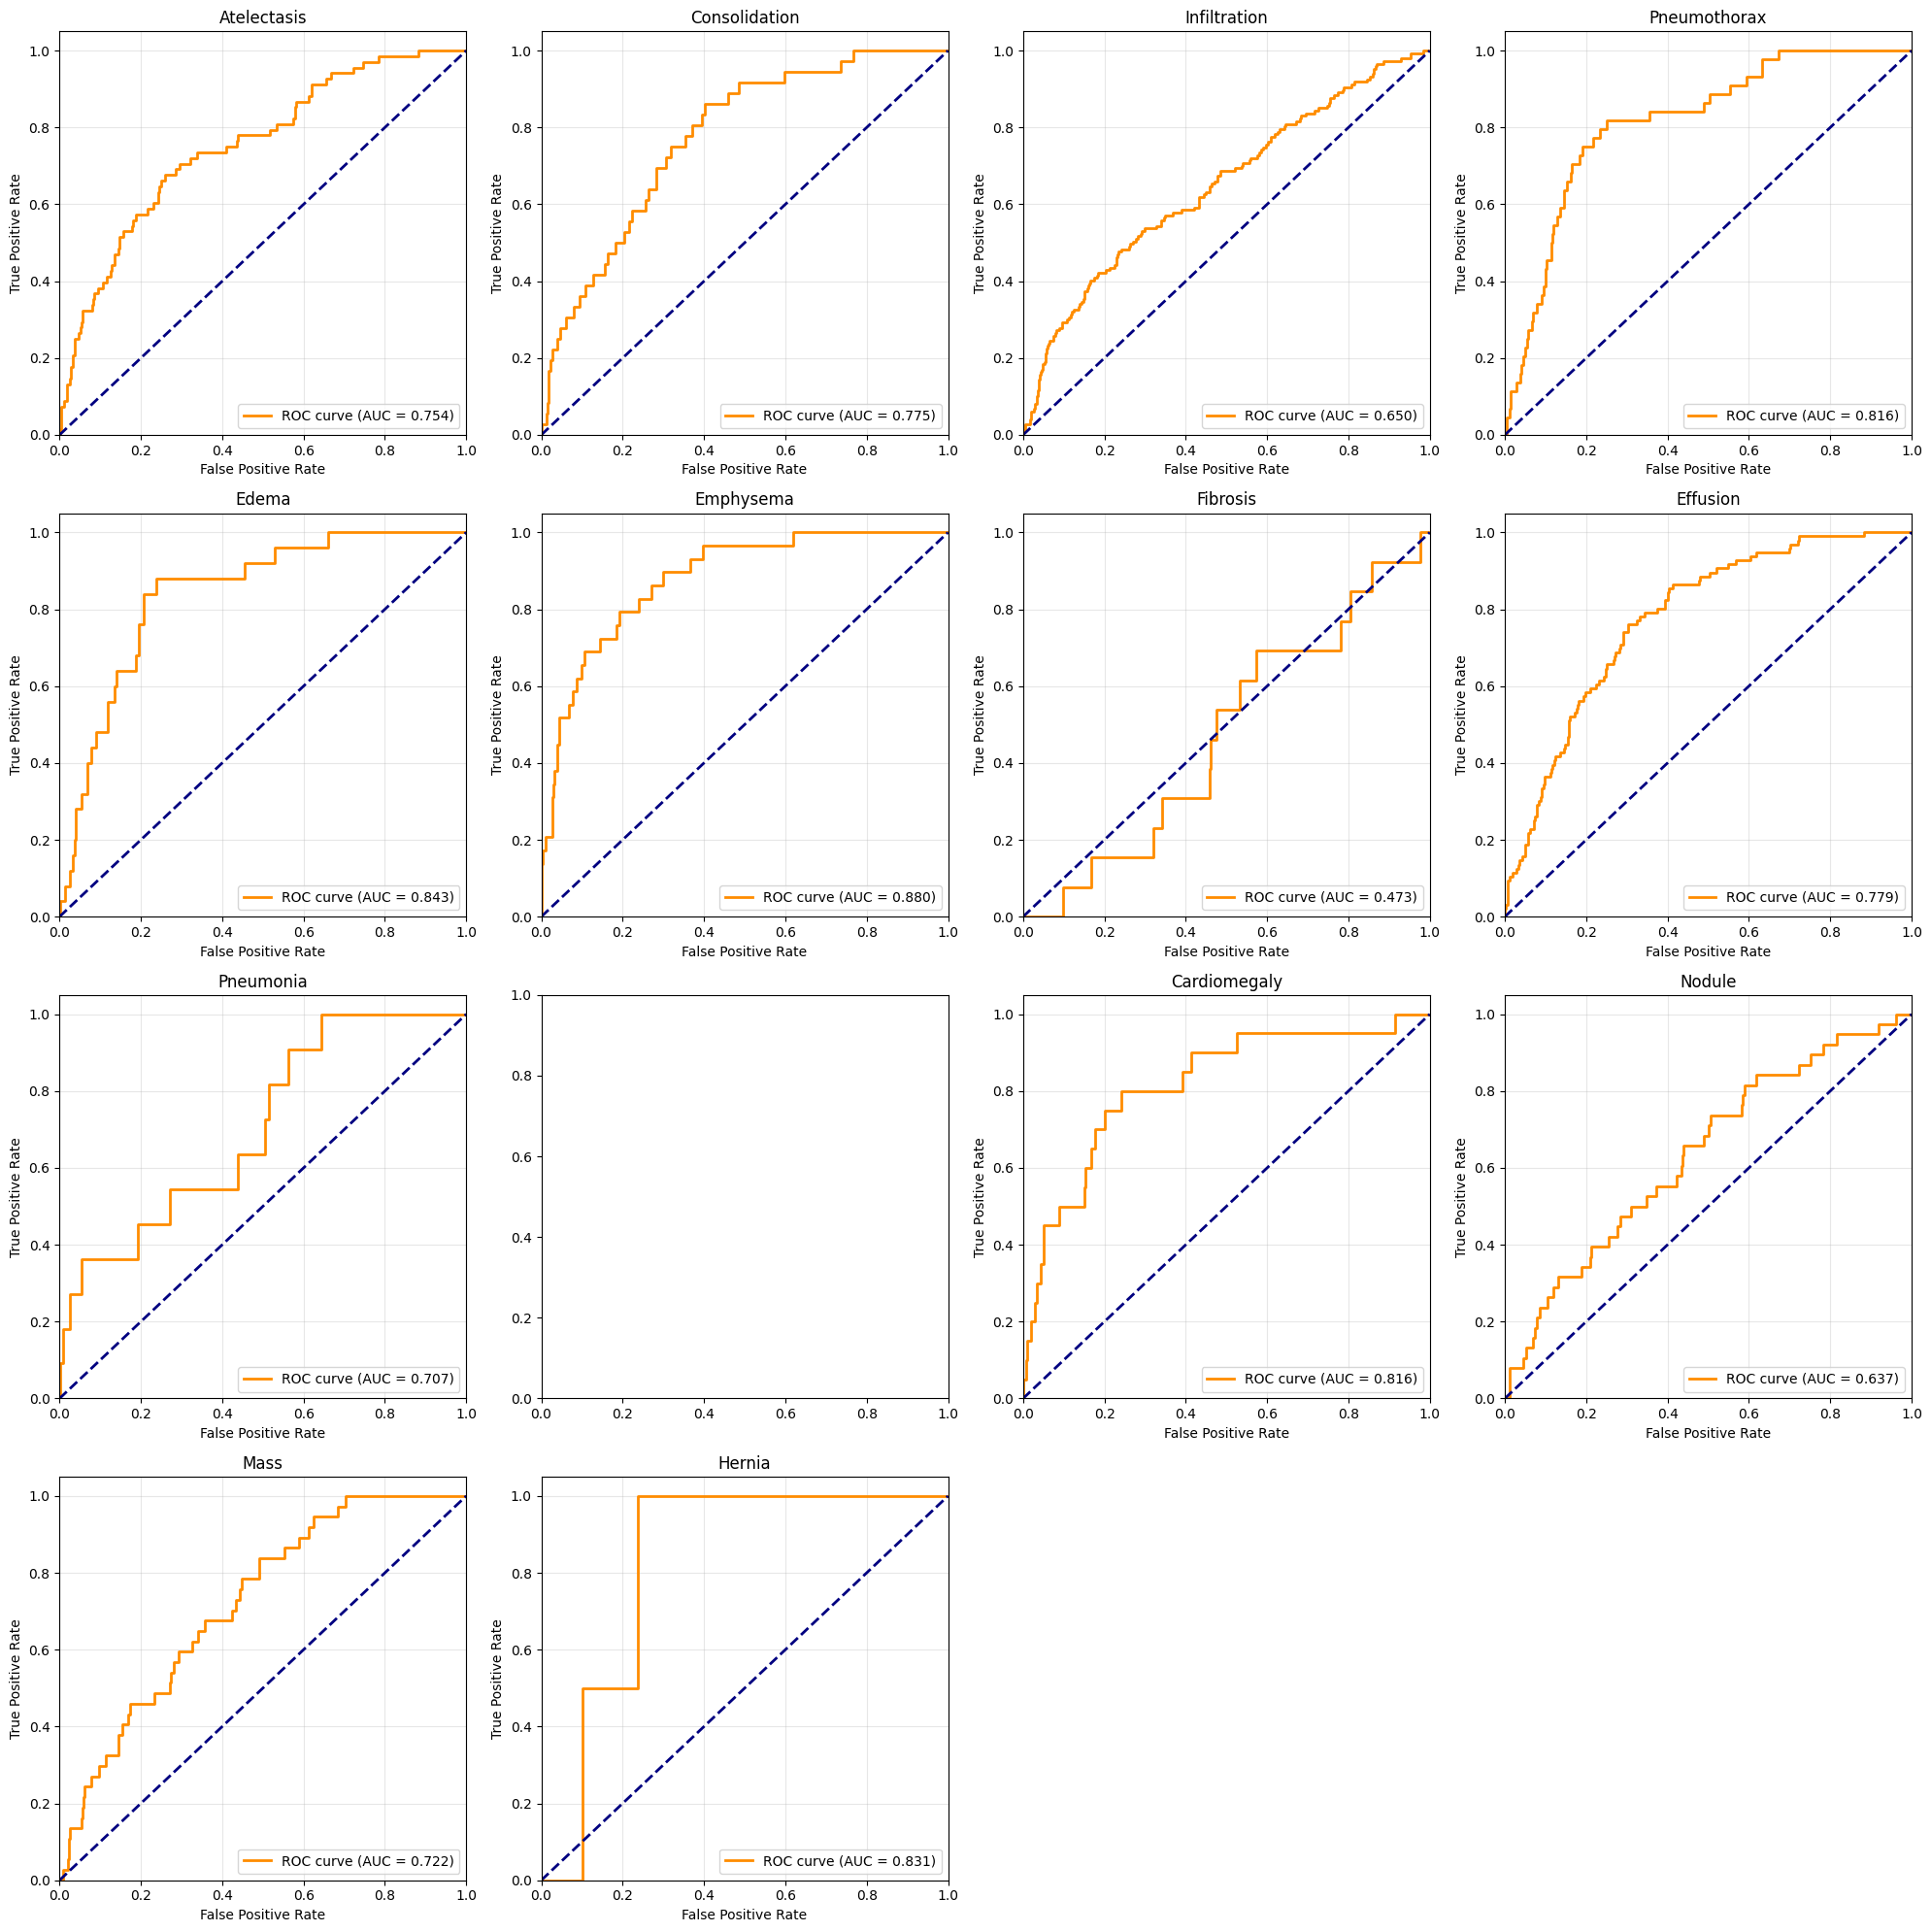

In [25]:
def plot_roc_curves(labels, predictions, disease_names):
    """Plot ROC curves for all diseases"""

    fig, axes = plt.subplots(4, 4, figsize=(20, 20))
    axes = axes.ravel()

    for i, disease in enumerate(disease_names):
        if i < 14 and len(np.unique(labels[:, i])) > 1:
            fpr, tpr, _ = roc_curve(labels[:, i], predictions[:, i])
            roc_auc = auc(fpr, tpr)

            axes[i].plot(fpr, tpr, color='darkorange', lw=2,
                        label=f'ROC curve (AUC = {roc_auc:.3f})')
            axes[i].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            axes[i].set_xlim([0.0, 1.0])
            axes[i].set_ylim([0.0, 1.05])
            axes[i].set_xlabel('False Positive Rate')
            axes[i].set_ylabel('True Positive Rate')
            axes[i].set_title(f'{disease}')
            axes[i].legend(loc="lower right")
            axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for i in range(14, 16):
        axes[i].axis('off')

    plt.tight_layout()
    plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n📈 Plotting ROC Curves...")
plot_roc_curves(test_metrics['labels'], test_metrics['predictions'], DISEASE_LABELS)

In [26]:
print("\n📥 Downloading Results...")

from google.colab import files

# Download files
files.download('best_model.pth')
files.download('test_results.json')
files.download('training_history.png')
files.download('roc_curves.png')
files.download('disease_distribution.png')
files.download('sample_images.png')

print("\n✅ All Done! Files downloaded.")
print("\n📊 Summary:")
print(f"   - Model: DenseNet-121")
print(f"   - Test AUC: {mean_auc:.4f}")
print(f"   - Test F1: {mean_f1:.4f}")
print(f"   - Best Epoch: {checkpoint['epoch'] + 1}")


📥 Downloading Results...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ All Done! Files downloaded.

📊 Summary:
   - Model: DenseNet-121
   - Test AUC: 0.7448
   - Test F1: 0.1704
   - Best Epoch: 9
